In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

# to beautify the spark dataframe
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Read data the processed data

In [3]:
# load the data into spark dataframe
tweets = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/sshende/processed_data')

23/03/06 08:09:10 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
tweets.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- id_str: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- country: string (nullable = true)
 |-- bounding_box: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- quote_count: long (nullable = true)
 |-- reply_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- statuses_count: long (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- coordinates: struct (nullable = true)
 |    |    |-- coordina

In [6]:
print("Number of rows:", tweets.count())
print("Number of columns:", len(tweets.columns))

Number of rows: 58482831
Number of columns: 17


In [ ]:
tweets.limit(5)

created_at,text,id,id_str,screen_name,description,verified,country,bounding_box,quote_count,reply_count,retweet_count,favorite_count,followers_count,statuses_count,retweeted_status,quoted_status
Tue Jul 19 13:44:...,RT @popeyeshub: w...,1504525151894966283,1504525151894966283,WholeLotOfAss4U,null,false,null,null,0,0,34,0,24,1219,"{null, Tue Jul 19...",null
Tue Jul 19 13:44:...,RT @MattWelch: Th...,41223975,41223975,LennyGoodnight,I'm just a simple...,false,null,null,0,0,21,0,383,23438,"{null, Tue Jul 19...","{null, Tue Jul 19..."
Tue Jul 19 13:44:...,RT @MarshaBlackbu...,1266152654981513216,1266152654981513216,Seeker1017,Waking up enlight...,false,null,null,0,0,1953,0,456,48356,"{null, Mon Jul 18...",null
Tue Jul 19 13:44:...,RT @ActivistLittl...,1356915591857102849,1356915591857102849,Keira55475429,Spring Revolution...,false,null,null,0,0,2,0,161,42615,"{null, Tue Jul 19...",null
Tue Jul 19 13:44:...,RT @emdashklatt: ...,20739133,20739133,DrJudyStone,Author: Resilienc...,false,null,null,0,0,6452,0,11676,272238,"{null, Mon Jul 18...",null


### Identify the most prolific / influential Twitterers

To identify the influential twitterers, we will only consider verified users because it is likely that the analyzed data will come from credible sources. Additionally, verified users are less likely to engage in spam or other malicious activity.

In [12]:
verified_tweets = tweets.filter(col('verified') == True)
print('Count of verified users:', verified_tweets.count())

Count of verified users: 853090


In [13]:
unverified_tweets = tweets.filter(col('verified') == False)
print('Count of unverified users:', unverified_tweets.count())

Count of unverified users: 57629741


In [14]:
# check the statistics of the features that could explain the influence of a twitterer
verified_tweets\
.select('quote_count','reply_count','retweet_count','favorite_count','followers_count', 'statuses_count')\
.describe().show()

+-------+-----------+-----------+-----------------+--------------+------------------+------------------+
|summary|quote_count|reply_count|    retweet_count|favorite_count|   followers_count|    statuses_count|
+-------+-----------+-----------+-----------------+--------------+------------------+------------------+
|  count|     853090|     853090|           310318|        853090|            853090|            853090|
|   mean|        0.0|        0.0|905.3600919057225|           0.0| 319603.7329121195|102324.21609208875|
| stddev|        0.0|        0.0|5544.324468390272|           0.0|1999968.2766245215|177514.29587530554|
|    min|          0|          0|                1|             0|                 0|                 1|
|    max|          0|          0|           306078|             0|         132031077|           9672592|
+-------+-----------+-----------+-----------------+--------------+------------------+------------------+



In [37]:
# create a dataframe and include the relevant features required to identify influential twitterers
influential_users = verified_tweets.select('id', 'screen_name', 'description', 'followers_count', 'statuses_count', 'retweeted_status', 'quoted_status')

#### By message volume (original content)

In [16]:
# keep only original tweets by filtering out retweets and quote tweets
original_tweets = influential_users.filter((col('retweeted_status').isNull()) & (col('quoted_status').isNull()))

In [ ]:
# Group by user and followers count, and statuses count
user_tweets = original_tweets.groupBy('id', 'screen_name') \
                            .agg(sum('followers_count').alias('followers_count'), 
                                 sum('statuses_count').alias('tweet_count'))

# Sort by the followers count, and statuses count in descending order
most_influential_users_by_tweets = user_tweets.sort(desc('followers_count'))

# Show top 10 most influential users by tweets
most_influential_users_by_tweets_pd = most_influential_users_by_tweets.select('screen_name', 'tweet_count').sort(desc('tweet_count')).limit(10).toPandas()
most_influential_users_by_tweets_pd

,screen_name,tweet_count
0,sportsthread,3464694372
1,KenyaPower_Care,2457606307
2,TOICitiesNews,984945717
3,Independent,572732353
4,thehill,526012187
5,htTweets,494465152
6,IndiaToday,386669798
7,WashTimes,385091572
8,FoxNews,383227359
9,inquirerdotnet,355464099


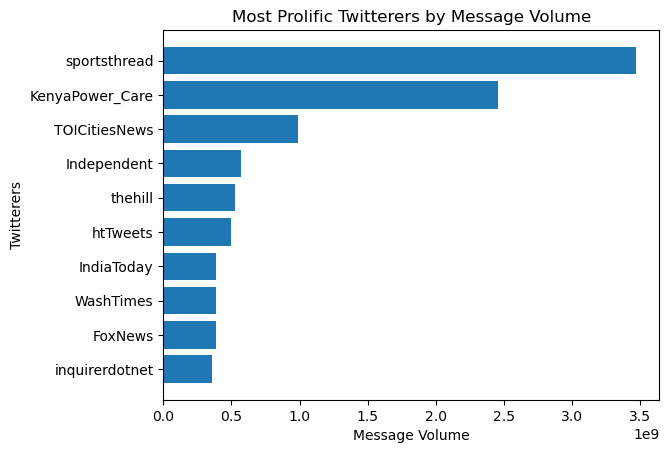

In [45]:
most_influential_users_by_tweets_pd = most_influential_users_by_tweets_pd.sort_values(by='tweet_count', ascending=True)

plt.barh(most_influential_users_by_tweets_pd['screen_name'], most_influential_users_by_tweets_pd['tweet_count'])
plt.title('Most Prolific Twitterers by Message Volume')
plt.xlabel('Message Volume')
plt.ylabel('Twitterers')
plt.show()

#### By message retweet (how often their messages are being retweeted)

In [31]:
# Group by user and followers count, and statuses count
user_retweets = influential_users.groupBy('id', 'screen_name') \
                            .agg(sum('followers_count').alias('followers_count'), 
                                 sum('retweeted_status.retweet_count').alias('retweet_count'))

# Sort by the followers count, and statuses count in descending order
most_influential_users_by_retweets = user_retweets.sort(desc('followers_count'))

# Show top 10 most influential users by tweets
most_influential_users_by_retweets_pd = most_influential_users_by_retweets.select('screen_name', 'retweet_count').sort(desc('retweet_count')).limit(10).toPandas()
most_influential_users_by_retweets_pd

,screen_name,retweet_count
0,ValaAfshar,1065671
1,LeratoMannya,835672
2,NasimiShabnam,810975
3,otepofficial,668361
4,JonesHospodTX,557165
5,ReignOfApril,459211
6,Bruno_J_Navarro,430919
7,AnsisEgle,402788
8,se4realhinton,386467
9,JeriLRyan,372764


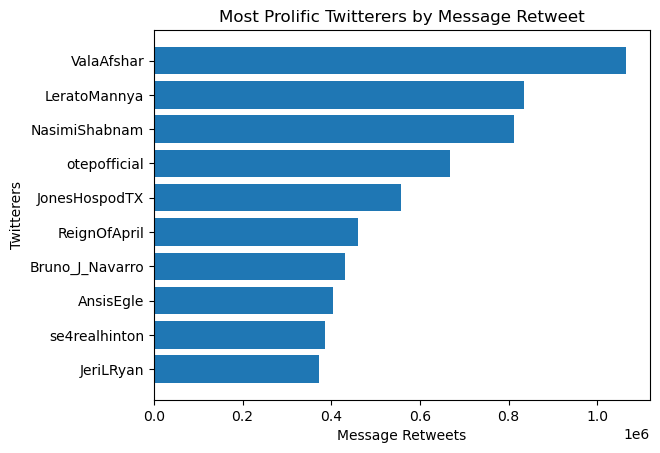

In [44]:
most_influential_users_by_retweets_pd = most_influential_users_by_retweets_pd.sort_values(by='retweet_count', ascending=True)

plt.barh(most_influential_users_by_retweets_pd['screen_name'], most_influential_users_by_retweets_pd['retweet_count'])
plt.title('Most Prolific Twitterers by Message Retweet')
plt.xlabel('Message Retweets')
plt.ylabel('Twitterers')
plt.show()

#### Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?

In [39]:
# identify the influential users baseed on the followers count
influential_users = influential_users \
                            .groupBy('id', 'screen_name', 'description') \
                            .agg(sum('followers_count').alias('follower_count'),
                                 sum('statuses_count').alias('tweet_count'),
                                 sum('retweeted_status.retweet_count').alias('retweet_count')) \
                            .sort(desc('follower_count'))

In [40]:
# Define keywords for different types of accounts
govt_keywords = ['government', 'official', 'politics', 'public service', 'state', 'federal', 'city', 'municipal', 'agency', 'parliament', 'elected', 'representative', 'legislation', 
                 'regulation', 'policy', 'public office', 'civil servant', 'bureaucracy', 'minister', 'governor', 'mayor', 'council', 'embassy', 'consulate', 'foreign affairs',
                 'homeland security', 'defense', 'military', 'law enforcement', 'justice', 'court', 'judge', 'prosecutor', 'immigration', 'customs', 'passport']
govt_keywords_str = '|'.join(govt_keywords)

edu_keywords = ['school', 'college', 'university', 'education', 'academy', 'students', 'professor', 'campus', 'degree', 'scholarship', 'research', 'faculty', 'lecture', 'curriculum',
                'syllabus', 'graduation', 'alumni', 'student government']
edu_keywords_str = '|'.join(edu_keywords)

nonprofit_keywords = ['non-profit', 'nonprofit', 'charity', 'foundation', 'ngo', 'non-governmental organization', 'social enterprise', 'community development', 'volunteer',
                      'service organization', 'social impact', 'public benefit organization','charitable trust', 'not-for-profit']
nonprofit_keywords_str = '|'.join(nonprofit_keywords)

news_keywords = ['news', 'media', 'journalism', 'press', 'reporting', 'reporter', 'anchor', 'editor', 'newspaper', 'broadcasting', 'newsroom', 'current events']
news_keywords_str = '|'.join(news_keywords)

influencer_keywords = ['influencer', 'blogger', 'vlogger', 'public figure', 'social media', 'coach', 'content creator', 'brand ambassador', 'fashionista', 'lifestyle guru', 
                       'fitness expert', 'beauty blogger', 'travel influencer', 'foodie', 'mommy blogger']
influencer_keywords_str = '|'.join(influencer_keywords)

health_keywords = ['health', 'healthcare', 'hospital', 'medical', 'doctor', 'nurse', 'wellness', 'public health', 'health promotion', 'health education', 'health policy',
                      'health services', 'health research', 'healthcare provider', 'healthcare system', 'disease']
health_keywords_str = '|'.join(health_keywords)

# Identify account type based on presence of keywords in user name or description
influential_users_type = influential_users.withColumn('account_type',
                           when((lower(influential_users['screen_name']).rlike(govt_keywords_str)) | 
                                (lower(influential_users['description']).rlike(govt_keywords_str)), 
                                'Government Entities')
                           .when((lower(influential_users['screen_name']).rlike(edu_keywords_str)) | 
                                (lower(influential_users['description']).rlike(edu_keywords_str)), 
                                'Education Organizations')
                           .when((lower(influential_users['screen_name']).rlike(nonprofit_keywords_str)) | 
                                (lower(influential_users['description']).rlike(nonprofit_keywords_str)), 
                                'Non-Profit Organizations')
                           .when((lower(influential_users['screen_name']).rlike(news_keywords_str)) | 
                                (lower(influential_users['description']).rlike(news_keywords_str)), 
                                'News Outlets')
                           .when((lower(influential_users['screen_name']).rlike(health_keywords_str)) | 
                                (lower(influential_users['description']).rlike(health_keywords_str)), 
                                'Health Organizations')
                           .when((lower(influential_users['screen_name']).rlike(influencer_keywords_str)) | 
                                (lower(influential_users['description']).rlike(influencer_keywords_str)) &
                                (influential_users['follower_count'] > 5000), 
                                'Social Media Influencers')
                           .otherwise('Other'))

In [41]:
# Count users by account type
users_by_account_type = influential_users_type.groupBy('account_type').agg(count('*').alias('count'))

# Show top 10 most influential account type
users_by_account_type_pd = users_by_account_type.select('account_type', 'count').sort( desc('count')).limit(10).toPandas()
users_by_account_type_pd

,account_type,count
0,Other,64094
1,News Outlets,37840
2,Government Entities,35327
3,Education Organizations,12777
4,Non-Profit Organizations,2253
5,Health Organizations,2222
6,Social Media Influencers,1699


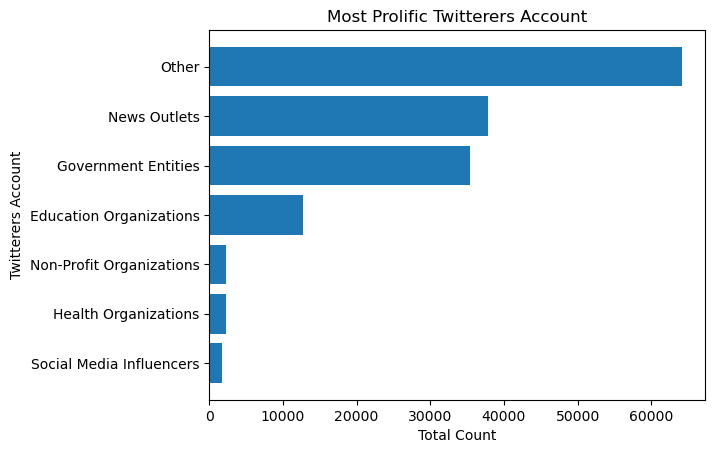

In [43]:
users_by_account_type_pd = users_by_account_type_pd.sort_values(by='count', ascending=True)

plt.barh(users_by_account_type_pd['account_type'], users_by_account_type_pd['count'])
plt.title('Most Prolific Twitterers Account')
plt.xlabel('Total Count')
plt.ylabel('Twitterers Account')
plt.show()

#### Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

In [46]:
# Group by account type and sum up the tweet and retweet counts
tweet_counts = influential_users_type.groupBy('account_type') \
                       .agg(sum('tweet_count').alias('tweets'),
                            sum('retweet_count').alias('retweets')) \
                       .toPandas()

In [47]:
tweet_counts

,account_type,tweets,retweets
0,Government Entities,13899815317,41060431
1,Other,18608949817,143496068
2,Non-Profit Organizations,541208767,3862020
3,Health Organizations,520005102,4994126
4,News Outlets,44755357782,64409256
5,Social Media Influencers,494246911,3591762
6,Education Organizations,8472181810,19535870


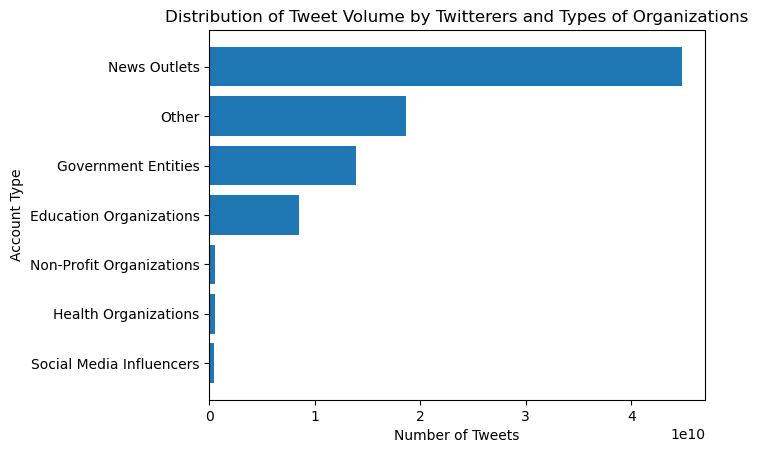

In [48]:
tweet_counts = tweet_counts.sort_values(by='tweets', ascending=True)

plt.barh(tweet_counts['account_type'], tweet_counts['tweets'])
plt.title('Distribution of Tweet Volume by Twitterers and Types of Organizations')
plt.xlabel('Number of Tweets')
plt.ylabel('Account Type')
plt.show()

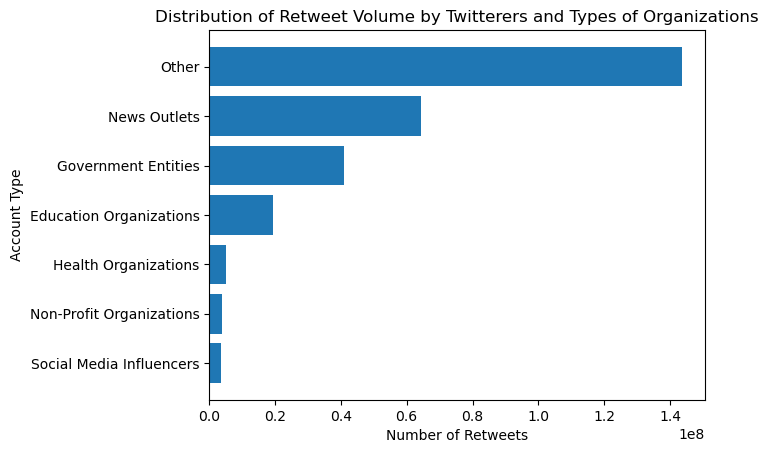

In [50]:
tweet_counts = tweet_counts.sort_values(by='retweets', ascending=True)

plt.barh(tweet_counts['account_type'], tweet_counts['retweets'])
plt.title('Distribution of Retweet Volume by Twitterers and Types of Organizations')
plt.xlabel('Number of Retweets')
plt.ylabel('Account Type')
plt.show()

### Where are these Twitterers (all of them, not just influencers) located?

In [53]:
tweet_country = tweets.filter(col('country').isNotNull())
tweet_country.count()

466979

In [58]:
tweet_country

created_at,text,id,id_str,screen_name,description,verified,country,bounding_box,quote_count,reply_count,retweet_count,favorite_count,followers_count,statuses_count,retweeted_status,quoted_status
Tue Jul 19 13:44:...,Excited to see a ...,14749672,14749672,DirectorCamWard,Director of AL Bu...,false,United States,"{[[[-88.473228, 3...",0,0,null,0,10969,10982,null,"{null, Tue Jul 19..."
Tue Jul 19 13:44:...,Year 7 attending ...,2313624048,2313624048,BryntegSchool,"Ewenny Road, Brid...",false,United Kingdom,"{[[[-3.613471, 51...",0,0,null,0,2622,7380,null,null
Tue Jul 19 13:45:...,Excited to be pla...,1310215317096980489,1310215317096980489,InclusionTips4,I am a young adul...,false,United States,"{[[[-75.563587, 3...",0,0,null,0,146,346,null,null
Tue Jul 19 13:46:...,Trying out someth...,1294832269090336768,1294832269090336768,HeyitsCassidy2,"Poet, Romantic, I...",false,United States,"{[[[-94.45916, 38...",0,0,null,0,141,1922,null,null
Tue Jul 19 13:46:...,@trishanelson52 A...,408014299,408014299,bigwaccer1979,null,false,United Kingdom,"{[[[-3.058666, 53...",0,0,null,0,714,3734,null,null
Tue Jul 19 13:47:...,@Jetsam_Shoes Bun...,1720641698,1720641698,MajesticResists,Blue dot in a Red...,false,United States,"{[[[-80.195561, 2...",0,0,null,0,12680,69433,null,null
Tue Jul 19 13:47:...,@john_litten @dan...,21907854,21907854,DanOMalley,Fmr. City Council...,false,United States,"{[[[-81.8375, 41....",0,0,null,0,1373,1107,null,null
Tue Jul 19 13:47:...,I went to school ...,547473175,547473175,fkhotidjah,facebook : fietri...,false,Kingdom of Saudi ...,"{[[[42.010156, 19...",0,0,null,0,91,404,null,"{null, Tue Jul 19..."
Tue Jul 19 13:48:...,- #NikolasCruz ph...,1416348636,1416348636,LittleLeighXoxo,❥But Cawfee First...,false,United States,"{[[[-74.041878, 4...",0,0,null,0,1241,93126,null,null
Fri Aug 26 20:21:...,👍👏🙄🫣🤯😅🤣😔?...,1487276690917281792,1487276690917281792,runnergirl1211,❤️ running and go...,false,United States,"{[[[-71.49717, 42...",0,0,null,0,3010,20177,null,"{null, Thu Aug 25..."


In [61]:
# group tweets by country and count the number of tweets
tweets_by_country = tweet_country \
                    .groupBy('country') \
                    .agg(countDistinct('id').alias('count')) \
                    .sort(desc('count')) \
                    .limit(10)

tweets_by_country_df = tweets_by_country.toPandas()
tweets_by_country_df

,country,count
0,United States,132384
1,Kingdom of Saudi Arabia,26257
2,United Kingdom,23181
3,India,13005
4,Nigeria,8448
5,Canada,7076
6,المملكة العربية السعودية,6249
7,South Africa,3633
8,Australia,3027
9,Republic of the Philippines,2606


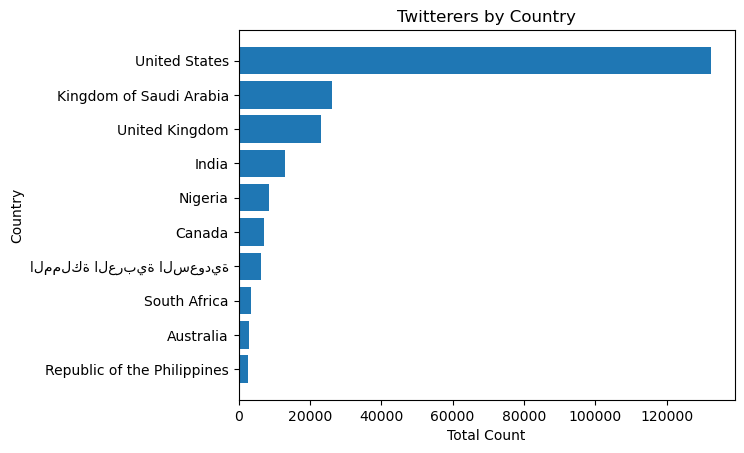

In [62]:
tweets_by_country_df = tweets_by_country_df.sort_values(by='count', ascending=True)

plt.barh(tweets_by_country_df['country'], tweets_by_country_df['count'])
plt.title('Twitterers by Country')
plt.xlabel('Total Count')
plt.ylabel('Country')
plt.show()

#### Do you see any relationship between the emergence of new issues in education and progression and locations of these Twitterers?

In [76]:
# create a dataframe with twitterer id, name, location and tweet
tweets_with_location = tweet_country \
                    .select('created_at', 'id', 'country', 'text')
tweets_with_location

created_at,id,country,text
Tue Jul 19 13:44:...,14749672,United States,Excited to see a ...
Tue Jul 19 13:44:...,2313624048,United Kingdom,Year 7 attending ...
Tue Jul 19 13:45:...,1310215317096980489,United States,Excited to be pla...
Tue Jul 19 13:46:...,1294832269090336768,United States,Trying out someth...
Tue Jul 19 13:46:...,408014299,United Kingdom,@trishanelson52 A...
Tue Jul 19 13:47:...,1720641698,United States,@Jetsam_Shoes Bun...
Tue Jul 19 13:47:...,21907854,United States,@john_litten @dan...
Tue Jul 19 13:47:...,547473175,Kingdom of Saudi ...,I went to school ...
Tue Jul 19 13:48:...,1416348636,United States,- #NikolasCruz ph...
Fri Aug 26 20:21:...,1487276690917281792,United States,👍👏🙄🫣🤯😅🤣😔?...


In [65]:
from pyspark.sql.window import Window

# Convert tweet_created_at to date
tweets_with_location = tweets_with_location.withColumn('created_at', to_date('created_at'))

# Group by date and user location to count number of tweets
tweets_count = tweets_with_location.groupBy('created_at', 'country').agg(count('*').alias('total_tweets'))

# Compute rolling average of total_tweets over 15 days for each location
window = Window.partitionBy('country').orderBy('created_at').rowsBetween(-14, 0)
tweets_count = tweets_count.withColumn('MA', count('*').over(window))

#filter tweets by keywords related to education issues
keywords = ['school closures', 'learning loss', 'teacher shortages', 'college affordability', 'bullying', 'school funding', 'student debt', 'school safety']
edu_issue_tweets = tweets_with_location.filter(lower(col('text')).rlike('|'.join(keywords)))

# Group by date and user location to count number of education-related tweets
edu_issue_tweets_count = edu_issue_tweets.groupBy('created_at', 'country').agg(count('*').alias('total_edu_tweets'))

# Compute rolling average of total_edu_tweets over 15 days for each location
edu_issue_tweets_count = edu_issue_tweets_count.withColumn('MA', count('*').over(window))

# Join the two DataFrames and compute correlation between total_tweets and total_edu_tweets
df_corr = tweets_count.join(edu_issue_tweets_count, ['created_at', 'country'], 'outer')
corr = df_corr.stat.corr('total_tweets', 'total_edu_tweets')


In [66]:
print('Correlation', corr)

Correlation -0.004393362104500021


Since, the correlation very close to zero, it can be concluded that there is not relationship between the emergence of new issues in education and progression and locations of these Twitterers

#### Visualize the geographical distribution

In [69]:
# extract longitude and latitude
tweets_location = tweet_country.selectExpr("bounding_box.coordinates[0][0][0] as longitude","bounding_box.coordinates[0][0][1] as latitude", 'id')
tweets_location.limit(5)

longitude,latitude,id
-3.398415,53.262098,2760673772
0.140821,51.500544,768369201820098560
36.050039,-3.070132,1439296405005275138
150.520929,-34.118347,299502506
-1.957296,50.574606,20263640


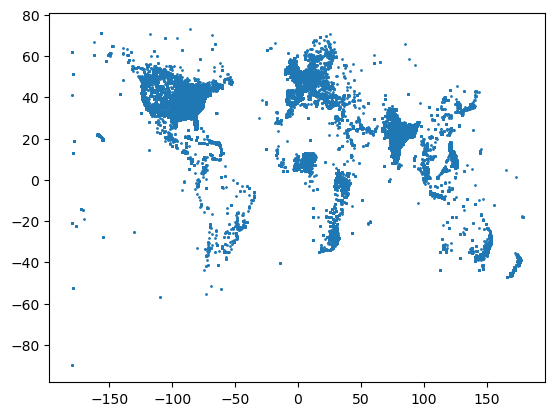

In [70]:
# convert to pandas dataframe for plotting
tweets_location_df = tweets_location.toPandas()

# create scatter plot
plt.scatter(tweets_location_df['longitude'], tweets_location_df['latitude'], s=1)

# show plot
plt.show()

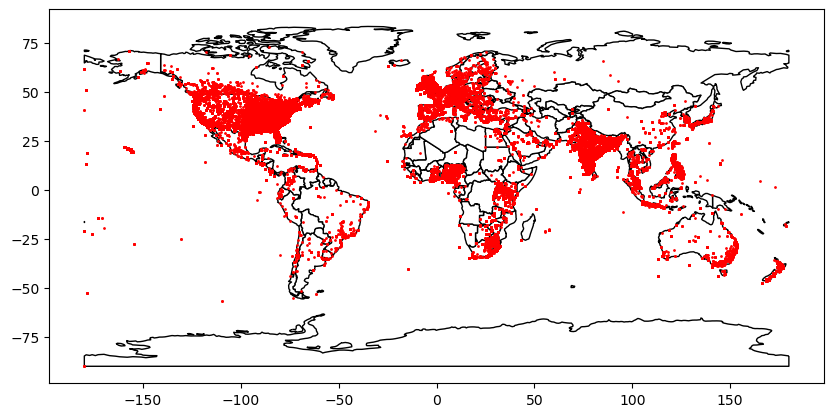

In [102]:
import geopandas as gpd

# Convert the latitude and longitude columns to floats
tweets_location = tweets_location.withColumn("latitude", col("latitude").cast("float"))
tweets_location = tweets_location.withColumn("longitude", col("longitude").cast("float"))

# Convert the DataFrame to a Pandas DataFrame
tweets_location_df = tweets_location.toPandas()

# Create a GeoDataFrame from the Pandas DataFrame
gdf = gpd.GeoDataFrame(tweets_location_df, geometry=gpd.points_from_xy(tweets_location_df.longitude, tweets_location_df.latitude))

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plot the GeoDataFrame on a world map
ax = world.plot(color="white", edgecolor="black", figsize=(10,10))
gdf.plot(ax=ax, color="red", markersize=1)
plt.show()

### What are the timelines of these tweets? Do you see significant peaks and valleys?

In [78]:
tweet_timeline = tweets_with_location.select('created_at', 'text').filter(col('created_at').isNotNull() & col('text').isNotNull())
tweet_timeline.limit(5)

created_at,text
Tue Jul 19 13:44:...,Excited to see a ...
Tue Jul 19 13:44:...,Year 7 attending ...
Tue Jul 19 13:45:...,Excited to be pla...
Tue Jul 19 13:46:...,Trying out someth...
Tue Jul 19 13:46:...,@trishanelson52 A...


In [103]:
# create a dataframe to get total tweets by created_at
tweet_timeline = tweet_timeline.groupBy('created_at').agg(count('*').alias('total_tweets'))

# convert the dataframe to pandas dataframe
tweet_timeline_df = tweet_timeline.toPandas()
tweet_timeline_df.head(5)

,created_at,total_tweets
0,Fri May 06 15:24:55 +0000 2022,1
1,Sat May 28 22:41:32 +0000 2022,1
2,Thu Jun 02 19:27:37 +0000 2022,1
3,Thu Jan 05 12:24:38 +0000 2023,1
4,Tue Jun 07 20:15:53 +0000 2022,1


#### Do you see any data collection gaps?

In [104]:
# convert "created_at" column to datetime format
tweet_timeline_df['created_at'] = pd.to_datetime(tweet_timeline_df['created_at'], errors='coerce')

In [105]:
tweet_timeline_df

,created_at,total_tweets
0,2022-05-06 15:24:55+00:00,1
1,2022-05-28 22:41:32+00:00,1
2,2022-06-02 19:27:37+00:00,1
3,2023-01-05 12:24:38+00:00,1
4,2022-06-07 20:15:53+00:00,1
...,...,...
452537,2022-05-21 05:47:23+00:00,1
452538,2022-05-23 12:31:28+00:00,1
452539,2022-06-29 01:41:10+00:00,1
452540,2023-01-20 00:06:14+00:00,1


In [88]:
#extract hour and find total count of tweets by hour of the day
tweet_timeline_df['hour'] = tweet_timeline_df['created_at'].dt.hour

tweet_timeline_by_hr = tweet_timeline_df.groupby('hour').agg(total_tweets=('total_tweets', 'sum'))
tweet_timeline_by_hr

,total_tweets
hour,
0,20819
1,20719
2,19623
3,17127
4,13961
5,11605
6,10641
7,10558
8,10952


In [91]:
# extract date and find count of tweets by day
tweet_timeline_df['date'] = tweet_timeline_df['created_at'].dt.date

tweet_timeline_by_day = tweet_timeline_df.groupby('date').agg(total_tweets=('total_tweets', 'sum'))
tweet_timeline_by_day

,total_tweets
date,
2022-04-05,1095
2022-04-06,1249
2022-04-07,1238
2022-04-08,1143
2022-04-09,1056
...,...
2023-02-04,1166
2023-02-05,971
2023-02-06,1154


In [92]:
#extract week and find total count of tweets by week
tweet_timeline_df['week'] = tweet_timeline_df['created_at'].dt.week

tweet_timeline_by_wk = tweet_timeline_df.groupby('week').agg(total_tweets=('total_tweets', 'sum'))
tweet_timeline_by_wk

,total_tweets
week,
1,7316
2,8232
3,8754
4,9328
5,9433
6,3154
14,6673
15,7784
16,8787


In [93]:
#extract month and find total count of tweets by month
tweet_timeline_df['month'] = tweet_timeline_df['created_at'].dt.month

tweet_timeline_by_month = tweet_timeline_df.groupby('month').agg(total_tweets=('total_tweets', 'sum'))
tweet_timeline_by_month

,total_tweets
month,
1,37279
2,9838
4,31848
5,43886
6,40260
7,37883
8,53139
9,52704
10,51207


In [94]:
#extract quarter and plot total count of tweets by quarter
tweet_timeline_df['quarter'] = tweet_timeline_df['created_at'].dt.quarter

tweet_timeline_by_qt = tweet_timeline_df.groupby('quarter').agg(total_tweets=('total_tweets', 'sum'))
tweet_timeline_by_qt

,total_tweets
quarter,
1,47117
2,115994
3,143726
4,145705


In [95]:
#extract year and plot total count of tweets by year
tweet_timeline_df['year'] = tweet_timeline_df['created_at'].dt.year

tweet_timeline_by_yr= tweet_timeline_df.groupby('year').agg(total_tweets=('total_tweets', 'sum'))
tweet_timeline_by_yr

,total_tweets
year,
2022,405425
2023,47117


Observed no data collection gaps

#### Plot the timelines of these tweets

<AxesSubplot:xlabel='hour'>

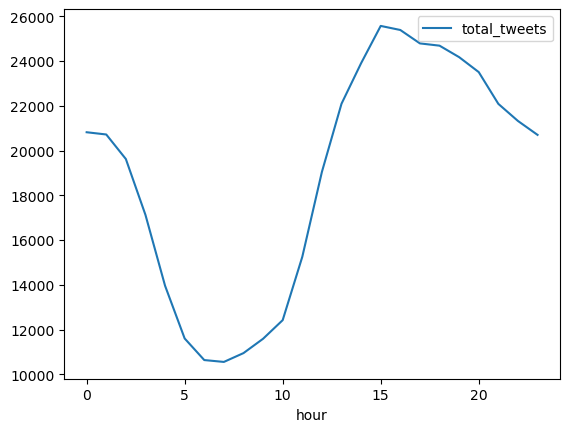

In [96]:
tweet_timeline_by_hr.plot(kind='line')

<AxesSubplot:xlabel='date'>

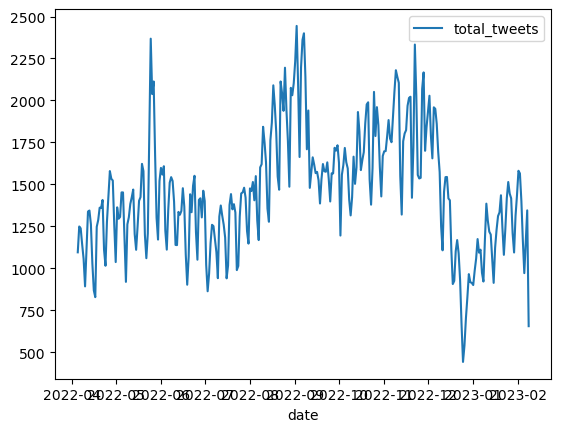

In [97]:
tweet_timeline_by_day.plot(kind='line')

<AxesSubplot:xlabel='week'>

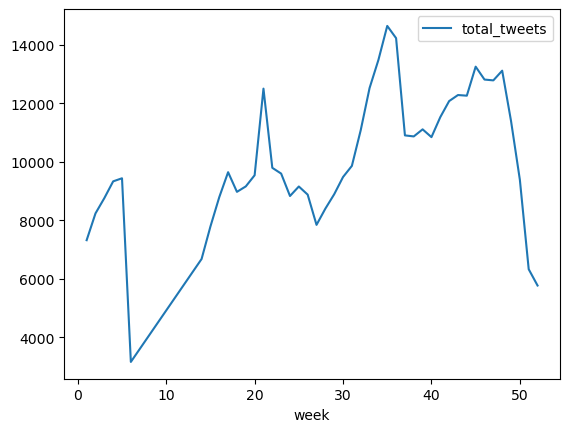

In [98]:
tweet_timeline_by_wk.plot(kind='line')

<AxesSubplot:xlabel='month'>

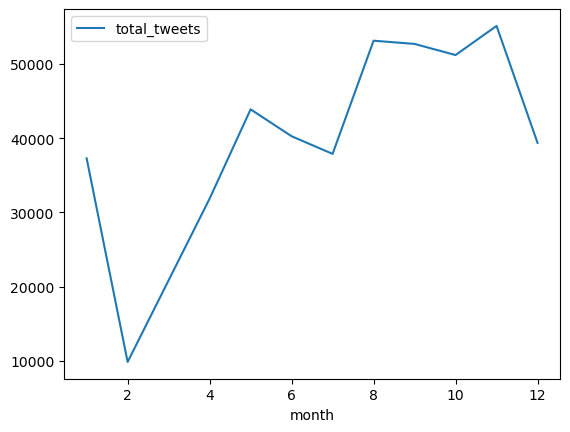

In [99]:
tweet_timeline_by_month.plot(kind='line')

<AxesSubplot:xlabel='quarter'>

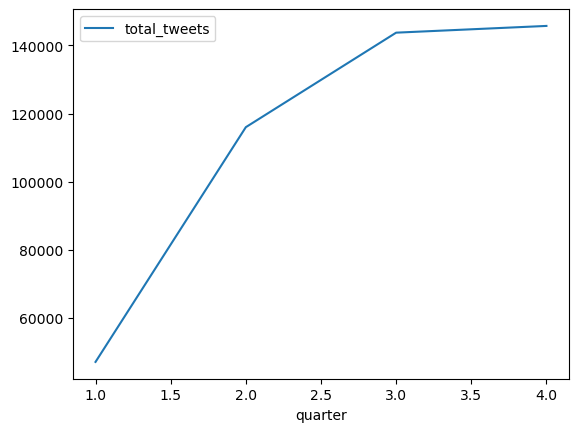

In [100]:
tweet_timeline_by_qt.plot(kind='line')

<AxesSubplot:xlabel='year'>

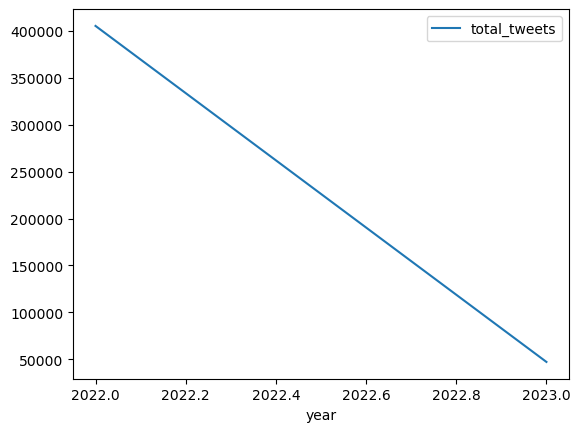

In [101]:
tweet_timeline_by_yr.plot(kind='line')